# Milestone 4 Task 3
In this notebook, we will analyze data from MNIST dataset.

## Load data

In [38]:
# Load Packages
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import wandb
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import os

In [39]:
# Load the data and split it between train and test sets
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)

x_train shape: (60000, 28, 28)
y_train shape: (60000,)
x_test shape: (10000, 28, 28)
y_test shape: (10000,)


## Explore data
### I. Explore whether the data is balanced (i.e., number of classes are uniform distributed)

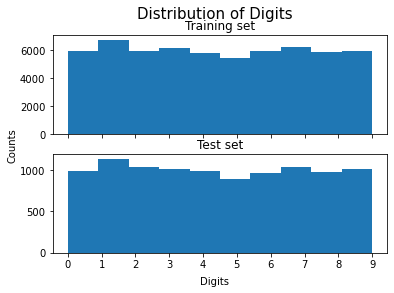

In [40]:
# Create a figure and an array of axes: 2 rows, 1 column
fig, ax = plt.subplots(2, 1, sharex=True)

#ax.xticks(range(0,10))
ax[0].hist(y_train, bins=10)
ax[1].hist(y_test, bins=10)

# Add labels and title
fig.suptitle("Distribution of Digits", fontsize=15)
fig.supylabel("Counts", fontsize=10)
fig.supxlabel("Digits", fontsize=10)
ax[0].title.set_text('Training set')
ax[1].title.set_text('Test set')
ax[1].set_xticks(range(0,10))

plt.show()

### II. Plot the a sample of first 10 images from this dataset.

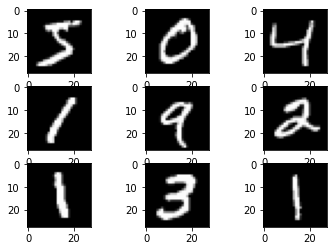

In [42]:
for i in range(9):  
 plt.subplot(330 + 1 + i)
 plt.imshow(x_train[i], cmap=plt.get_cmap('gray'))

### III. Observe the distribution of greyscale values.
In the MNIST input data, pixel values range from 0 (black background) to 255 (white foreground). The parameter `bins` determines the number of bins to use for the histogram. We pass in 256 because we want to see the pixel count for each of the 256 possible values in the grayscale image.

The first output `histogram` of the np.histogram function is a one-dimensional NumPy array, with 256 rows and one column, representing the number of pixels with the intensity value corresponding to the index. I.e., the first number in the array is the number of pixels found with intensity value 0, and the final number in the array is the number of pixels found with intensity value 255. The second output `bin_edges` of np.histogram is an array with the bin edges and one column and 257 rows (one more than the histogram itself). There are no gaps between the bins, which means that the end of the first bin, is the start of the second and so on. For the last bin, the array also has to contain the stop, so it has one more element, than the histogram.

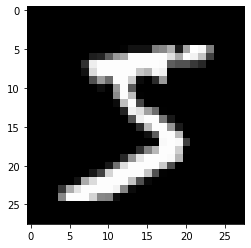

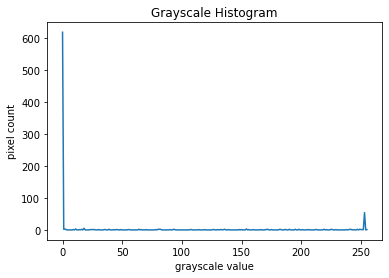

In [5]:
# Show first image in the training set
plt.imshow(x_train[0], cmap=plt.get_cmap('gray'))

# Create the histogram of grayscale value
histogram, bin_edges = np.histogram(x_train[0], bins=256, range=(0, 256))
# Configure and draw the histogram figure
plt.figure()
plt.title("Grayscale Histogram")
plt.xlabel("grayscale value")
plt.ylabel("pixel count")

plt.plot(bin_edges[0:-1], histogram) 

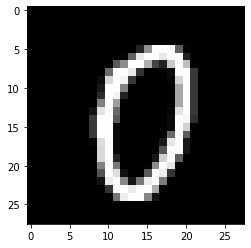

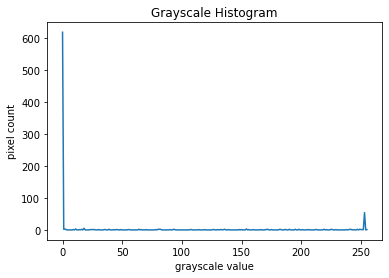

In [45]:
# Show the 1000th image in the training set
plt.imshow(x_train[1000], cmap=plt.get_cmap('gray'))

# Create the histogram of grayscale value
histogram, bin_edges = np.histogram(x_train[0], bins=256, range=(0, 256))
# Configure and draw the histogram figure
plt.figure()
plt.title("Grayscale Histogram")
plt.xlabel("grayscale value")
plt.ylabel("pixel count")

plt.plot(bin_edges[0:-1], histogram) 

## Make prediction with best model

In this section, the best model with highest validation accuracy is used to make predictions.

First, we need to process test dataset.


In [52]:
# Process data
x_test = x_test.astype("float32") / 255
x_test = np.expand_dims(x_test, -1)
y_test = tf.keras.utils.to_categorical(y_test, 10)

print(x_test.shape[0], "test samples")
print("x_test shape:", x_test.shape)
print("y_test shape", y_test.shape)

10000 test samples
x_test shape: (10000, 28, 28, 1)
y_test shape (10000, 10)


We find the best sweep resulting the highest validation accuracy is `daily-sweep-1`. We then download the best model file from this sweep from Wandb by specifying the `api.sweep("<entity>/<project>/<sweep_id>")`

In [53]:
api = wandb.Api()
sweep = api.sweep("ds_group1/DS-project/ug4q5656")

# Best model
runs = sorted(sweep.runs, key=lambda run: run.summary.get("val_acc", 0), reverse=True)
val_acc = runs[0].summary.get("val_acc", 0)
print(f"Best run {runs[0].name} with {val_acc}% validation accuracy")

# Download model file
best_run = runs[0]
artifacts = best_run.logged_artifacts()
best_model = [artifact for artifact in artifacts if artifact.type == 'model'][3]
best_model.download()

# Get the path of downloaded model
path = os.path.dirname(os.path.abspath("ms4_task3"))+ "/artifacts/model-daily-sweep-1:v3"
print(path)

# Load the model
model = tf.saved_model.load(path)
print("sucessfully load the model")

Best run daily-sweep-1 with 0.9900000095367432% validation accuracy


wandb:   5 of 5 files downloaded.  


/home/serena/git_env/demoRepo/src/artifacts/model-daily-sweep-1:v3
sucessfully load the model


We make prediction and convert the prediction results into numpy array.

In [54]:
prediction = model(x_test).numpy()
print("prediction shape:", prediction.shape)

2023-01-04 16:22:01.136956: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 865280000 exceeds 10% of free system memory.


prediction shape: (10000, 10)


Finally, we use `confusion_matrix` from `Scikit-Learn` module to create confusion matrix

In [55]:
confusion = confusion_matrix(np.argmax(y_test,axis=1),np.argmax(prediction, axis=1))

In [56]:
print(confusion)

[[ 975    0    1    0    0    0    1    2    1    0]
 [   0 1133    1    0    0    0    1    0    0    0]
 [   2    3 1020    0    1    0    1    4    1    0]
 [   0    0    1 1002    0    4    0    2    1    0]
 [   0    0    0    0  977    0    1    0    0    4]
 [   0    0    0    3    0  887    1    1    0    0]
 [   3    2    0    0    2    2  949    0    0    0]
 [   0    2    5    1    0    1    0 1017    1    1]
 [   1    0    2    1    1    1    1    3  960    4]
 [   2    1    0    0    4    4    0    5    3  990]]


Alternatively, we can show confusion matrix in the follow way.

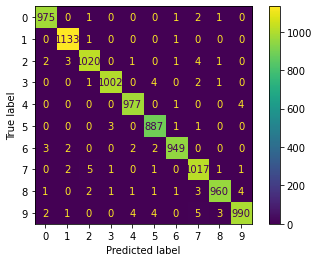

In [57]:
labels = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
cmd = ConfusionMatrixDisplay(confusion, display_labels=labels)
cmd.plot()